In [1]:
import re
import os
import ast
import mdpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# interceptamos las respuestas reales contra las predichas
df = pd.read_excel("ignorar/comprar_resultados.xlsx")
df['columnas realidad'] = df['columnas realidad'].apply(ast.literal_eval)
df['columnas ejecuciones'] = df['columnas ejecuciones'].apply(ast.literal_eval)

for i, fila in df.iterrows():
    if not fila['ejecutar']:
        continue
    respuesta_real = pd.DataFrame()
    
    with open(fila['archivo realidad'],'r') as f:
        contenido:str = f.read()
        inicio = contenido.find("INFO: resultado: '''") - len("INFO: resultado: '''") - 1
        fin = contenido.find(" '''\nWARNING: }") - 1
        
        respuesta_real = mdpd.from_md(contenido[inicio : fin])
    
    respuestas_predichas = []
    with open(fila['archivo ejecuciones'], 'r') as f:
        contenido:str = f.read()
        
        inicios = [inicio.end () for inicio in re.finditer("INFO: resultado: '''", contenido)]
        finales = [final.start() for final in re.finditer(" '''\nWARNING: }", contenido)]
        tiempos = [final.group(1) for final in re.finditer(r"INFO: tiempo: (\d*.\d*),", contenido)]
        for i in range(len(inicios)):
            respuestas_predichas.append(mdpd.from_md(contenido[inicios[i] + 1: finales[i]-1]))
    
    
    resultados = []
    
    for prediccion, tiempo in zip(respuestas_predichas, tiempos):
        
        resumen = {}
        resumen['Cantidad de respuestas esperadas'] = len(respuesta_real)
        resumen['Cantidad de respuesta predichas'] = len(prediccion) 
        resumen['Tiempo de ejecución'] = tiempo

        if prediccion.empty:
            prediccion = pd.DataFrame(columns=fila['columnas ejecuciones'])
        
        # Aqui procesaremos los datos de las predicciones por si tienen
        # algun caracter extraño. Caracteres extraños detectados:
        #    - \xa0: Un especie de espacio en blanco que no es el mismo caracter
        #            que el verdadero espacio en blanco
        
        tuplas_prediccion = []
        for record in prediccion.itertuples(index=False, name=None):
            tupla = []
            for i in range(len(fila['columnas ejecuciones'])):
                if isinstance(record[i], str):
                    tupla.append(record[i].replace(u'\xa0', u' '))
                else:
                    tupla.append(record[i])
                    
            tuplas_prediccion.append(tuple(tupla))
        
        tuplas_realidad = list(respuesta_real.itertuples(index=False, name=None))
        
        resumen['Cantidad de respuestas predichas que son correctas'] = len(set(tuplas_realidad).intersection(set(tuplas_prediccion)))
        resultados.append(resumen)   
    
    with open(fila['archivo resultado'], 'w') as f:
        for i, resultado in enumerate(resultados):
            f.write(f"\n@ Metricas de la ejecución {i+1}\n")
            f.write(f"metricas: {resultado}\n")

In [ ]:
# Juntamos todas las metricas
carpeta_metricas = 'resultados\metricas\ln\llama2-uncensored'
nombre_archivos = os.listdir(carpeta_metricas)
for i, nombre in enumerate(nombre_archivos):
    resumenes = []
    with open(os.path.join(carpeta_metricas, nombre),'r') as f:
        contenido = f.read()
        resumenes = [ast.literal_eval(diccionario.group(1)) for diccionario in re.finditer(r'metricas: (.*)\n',contenido)]
    
    precision_avg = 0
    recall_avg = 0
    time_avg = 0
    for resumen in resumenes:
        if resumen['Cantidad de respuesta predichas'] != 0:
            precision_avg += (resumen['Cantidad de respuestas predichas que son correctas'] / resumen['Cantidad de respuesta predichas']) * 1/len(resumenes)
        
        recall_avg += (resumen['Cantidad de respuestas predichas que son correctas']/ resumen['Cantidad de respuestas esperadas'])* 1/len(resumenes)
        
        time_avg += float(resumen['Tiempo de ejecución']) * 1/len(resumenes)
    
    with open(os.path.join(carpeta_metricas, 'resumen.txt'),'a') as f:
        f.write(f"\n@ Resumen de las metricas de la ejecución {i+1}\n")
        f.write(f"Precisión media: {precision_avg}\nRecall media: {recall_avg}\ntiempo medio: {time_avg}\n")

In [59]:
# cargamos los queries
queries = pd.read_excel('./ignorar/queries_ejecutar_modificados.xlsx')['query'].to_list()
modelos = ['llama2-uncensored', 'llama3', 'gemma']
carpeta_metricas = 'resultados/metricas/queries'
metricas = ['precision', 'recall']

datos_precision = []
datos_recall = []

for metrica in metricas:
    for modelo in modelos:
        archivos = os.listdir(os.path.join(carpeta_metricas, modelo))
        for i, archivo in enumerate(archivos):
            with open(os.path.join(carpeta_metricas, modelo, archivo),'r') as f:
                contenido = f.read()
                resumenes = [ast.literal_eval(diccionario.group(1)) for diccionario in re.finditer(r'metricas: (.*)\n',contenido)]
            
            for j, resumen in enumerate(resumenes):
                nueva_fila = [queries[i], j + 1, modelo]
                
                if metrica == 'precision':
                    if  resumen['Cantidad de respuesta predichas'] == 0:
                        nueva_fila.append(0)
                    else:
                        nueva_fila.append(round(resumen['Cantidad de respuestas predichas que son correctas'] / resumen['Cantidad de respuesta predichas'],2))
                        
                    nueva_fila.append(round(float(resumen['Tiempo de ejecución']), 3))
                    datos_precision.append(nueva_fila)
                elif metrica == 'recall':
                    nueva_fila += [round(resumen['Cantidad de respuestas predichas que son correctas']/ resumen['Cantidad de respuestas esperadas'], 2), round(float(resumen['Tiempo de ejecución']), 3)]
                    datos_recall.append(nueva_fila)


datos_precision_df = pd.DataFrame(datos_precision, columns=['query', 'nro.Ejecución', 'modelo', 'precision', 'tiempo'])
datos_recall_df = pd.DataFrame(datos_recall, columns=['query', 'nro.Ejecución', 'modelo', 'recall', 'tiempo'])

# excel_writer = pd.ExcelWriter(os.path.join(carpeta_metricas, 'resumen.xlsx'))
# datos_precision_df.to_excel(excel_writer, 'precision', index=False)
# datos_recall_df.to_excel(excel_writer, 'recall', index=False)
# excel_writer.close()

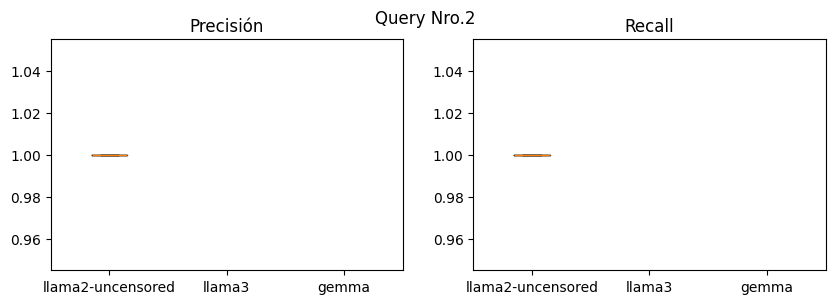

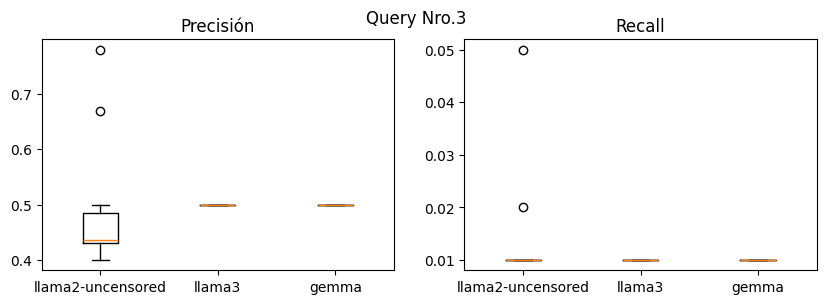

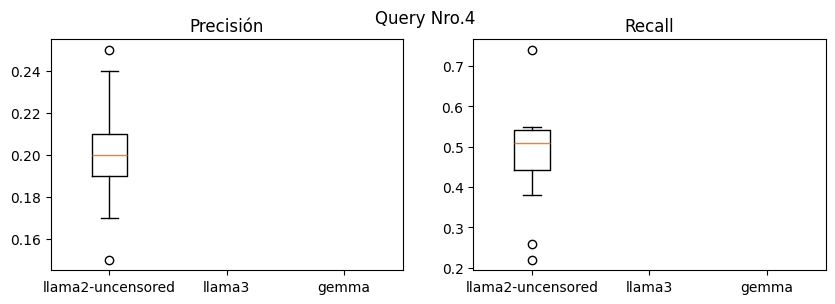

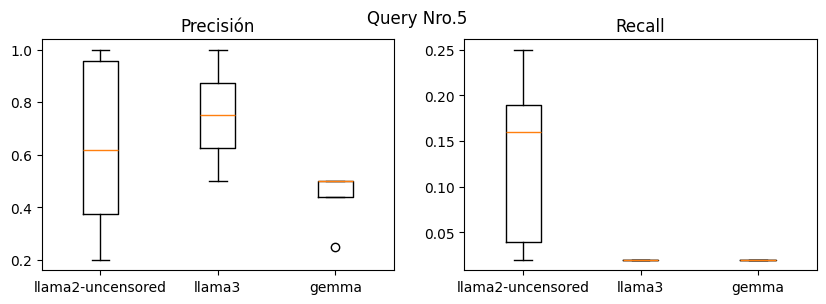

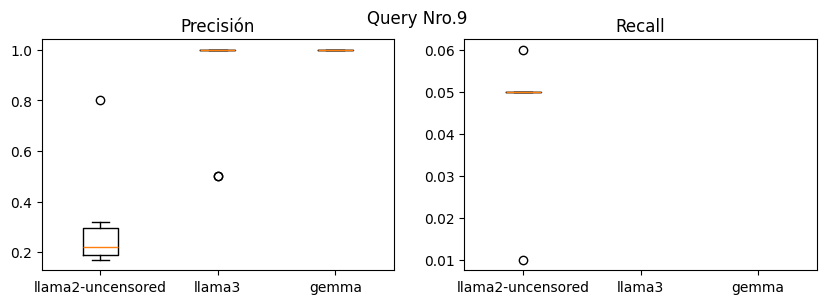

In [60]:
for i, query in enumerate(datos_precision_df['query'].unique()):
    data_precision = []
    data_recall = []
    for modelo in modelos:
        data_precision.append(datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] != 0)]['precision'].to_list()) 
        data_recall.append(datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] != 0)]['recall'].to_list()) 

    if data_precision !=[[],[],[]]: 
        fig, axs = plt.subplots(1,2,figsize=(10,3))
        fig.suptitle(f"Query Nro.{i+1}")
        axs[0].set_title('Precisión')
        axs[0].boxplot(data_precision, tick_labels=modelos)

        axs[1].set_title('Recall')
        axs[1].boxplot(data_recall, tick_labels= modelos)
        plt.show()

In [61]:
modelos = ['llama2-uncensored', 'llama3', 'gemma']

precision_iguales_cero = {}
precision_distintos_cero = {}
recall_iguales_cero = {}
recall_distintos_cero = {}

for modelo in modelos:
    nueva_fila_precision_iguales_cero = []
    nueva_fila_precision_distintos_cero = []
    nueva_fila_recall_iguales_cero = []
    nueva_fila_recall_distintos_cero = []
    
    for query in datos_precision_df['query'].unique():
        nueva_fila_precision_iguales_cero.append(len(datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] == 0)]))
        nueva_fila_precision_distintos_cero.append(len(datos_precision_df.loc[(datos_precision_df['modelo'] == modelo) & (datos_precision_df['query'] == query) & (datos_precision_df['precision'] != 0)]))
        
        nueva_fila_recall_iguales_cero.append(len(datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] == 0)]))
        nueva_fila_recall_distintos_cero.append(len(datos_recall_df.loc[(datos_recall_df['modelo'] == modelo) & (datos_recall_df['query'] == query) & (datos_recall_df['recall'] != 0)]))

    precision_iguales_cero[modelo]= nueva_fila_precision_iguales_cero
    precision_distintos_cero[modelo]= nueva_fila_precision_distintos_cero
    recall_iguales_cero[modelo]= nueva_fila_recall_iguales_cero
    recall_distintos_cero[modelo]= nueva_fila_recall_distintos_cero
    
        

In [62]:
def diagrama_barra_agrupados(datos, 
                            xlables: list[str], 
                            figsize: tuple[float, float], 
                            ylabel: str,
                            title: str,
                            ylim: list[float]):

    x = np.arange(len(xlables))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, values in datos.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width, xlables)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(*ylim)

    plt.show()

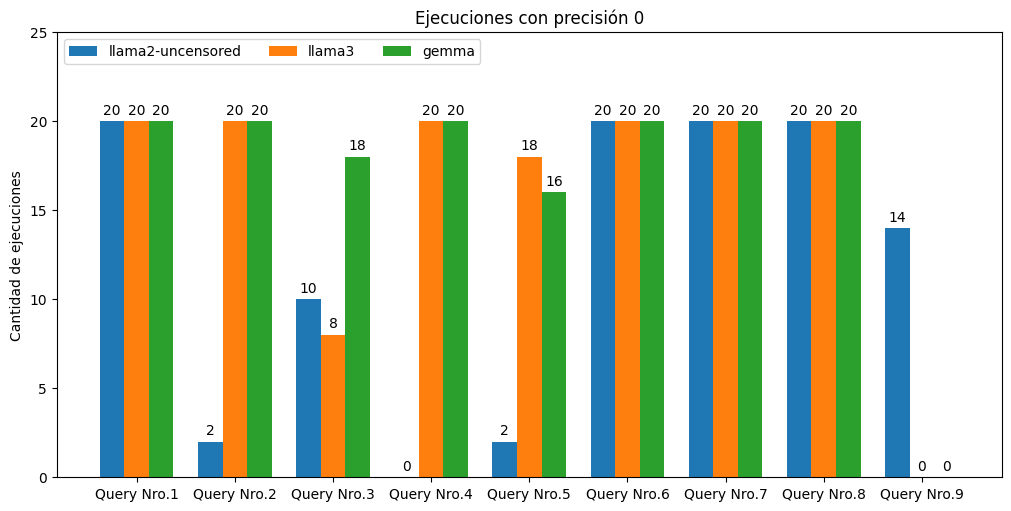

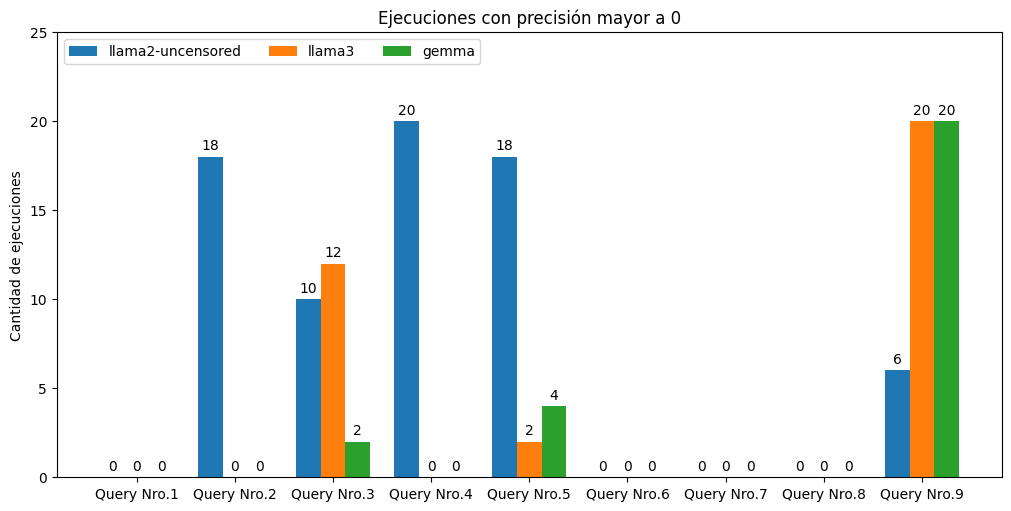

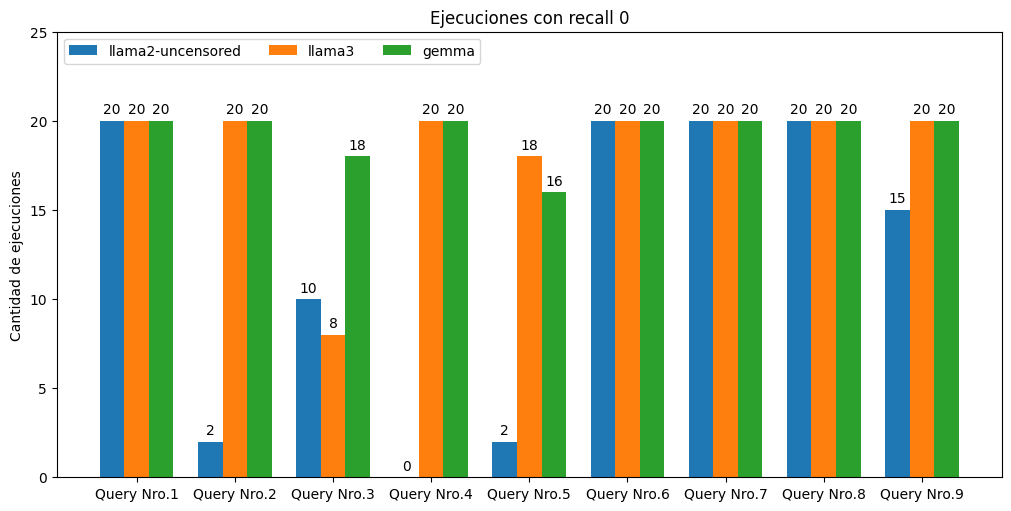

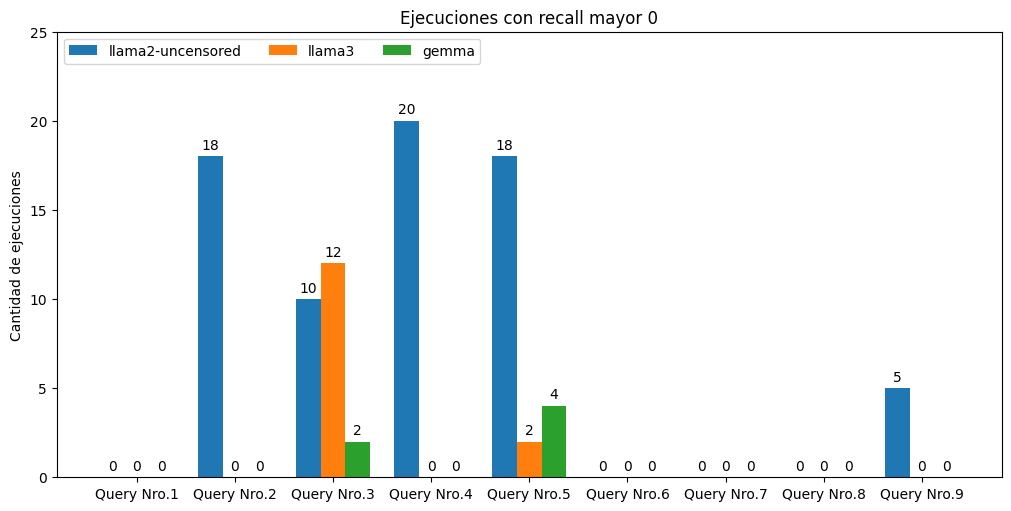

In [64]:
diagrama_barra_agrupados(precision_iguales_cero,
                        [f"Query Nro.{i + 1}" for i in range(len(datos_precision_df['query'].unique()))],
                        (10, 5),
                        'Cantidad de ejecuciones',
                        'Ejecuciones con precisión 0',
                        [0, 25])

diagrama_barra_agrupados(precision_distintos_cero,
                        [f"Query Nro.{i + 1}" for i in range(len(datos_precision_df['query'].unique()))],
                        (10, 5),
                        'Cantidad de ejecuciones',
                        'Ejecuciones con precisión mayor a 0',
                        [0, 25])

diagrama_barra_agrupados(recall_iguales_cero,
                        [f"Query Nro.{i + 1}" for i in range(len(datos_recall_df['query'].unique()))],
                        (10, 5),
                        'Cantidad de ejecuciones',
                        'Ejecuciones con recall 0',
                        [0, 25])

diagrama_barra_agrupados(recall_distintos_cero,
                        [f"Query Nro.{i + 1}" for i in range(len(datos_recall_df['query'].unique()))],
                        (10, 5),
                        'Cantidad de ejecuciones',
                        'Ejecuciones con recall mayor 0',
                        [0, 25])